In [ ]:
import os
import json
import gzip
import pandas as pd
import keras
from urllib.request import urlopen

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv

--2021-09-17 08:22:45--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  25.2MB/s    in 0.6s    

2021-09-17 08:22:46 (25.2 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]



In [ ]:
df = pd.read_csv('All_Beauty.csv')
df.head

<bound method NDFrame.head of         0143026860  A1V6B6TNIC10QE  1.0  1424304000
0       0143026860  A2F5GHSXFQ0W6J  4.0  1418860800
1       0143026860  A1572GUYS7DGSR  4.0  1407628800
2       0143026860   A1PSGLFK1NSVO  5.0  1362960000
3       0143026860   A6IKXKZMTKGSC  5.0  1324771200
4       0143026860  A36NF437WZLQ9E  5.0  1267142400
...            ...             ...  ...         ...
371339  B01HJEGTYK  A202DCI7TV1022  1.0  1500508800
371340  B01HJEGTYK  A3FSOR5IJOFIBE  5.0  1489622400
371341  B01HJEGTYK  A1B5DK6CTP2P24  5.0  1488326400
371342  B01HJEGTYK  A23OUYS5IRMJS9  2.0  1487635200
371343  B01HJEGTYK  A24KQ9RVU81L87  2.0  1481760000

[371344 rows x 4 columns]>

In [ ]:
df.iloc[0]

0143026860            0143026860
A1V6B6TNIC10QE    A2F5GHSXFQ0W6J
1.0                            4
1424304000            1418860800
Name: 0, dtype: object

In [ ]:
df.columns = ['asin','reviewerID','overall','time']

In [ ]:
df.value_counts('overall')

overall
5.0    229549
4.0     52687
1.0     39260
3.0     29555
2.0     20293
dtype: int64

Removing old data by converting unix timestamp to readable date


In [ ]:
from datetime import datetime
time1 = []
for i in df.time:
  k = datetime.fromtimestamp(i).strftime("%Y/%d/%m")
  time1.append(k)


In [ ]:
time1 = pd.DataFrame(time1, columns=['time1'])

In [ ]:
df = pd.concat([df,time1], axis = 1)

In [ ]:

def year_extractor(time1):
  year = time1[:4]
  return year


df['Year'] = df['time1'].apply(year_extractor)

In [ ]:
df['Year'].value_counts()

2016    101425
2017     70254
2015     69507
2014     39257
2018     30377
2013     26407
2012      9584
2011      6591
2010      5084
2009      4029
2008      3683
2007      3072
2006       946
2005       560
2004       292
2003       119
2002        78
2001        66
2000        13
Name: Year, dtype: int64

In [ ]:
df.Year = df.Year.astype(int)

In [ ]:
df = df[df['Year'] >= 2013]

In [ ]:
counts = df.nunique()
counts

asin           30968
reviewerID    296482
overall            5
time            2101
time1           2101
Year               6
dtype: int64

In [ ]:
df.isna().sum().sum()

0

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
ratings = df.overall
user = df.reviewerID
userID = user.to_numpy()
userID_unique = np.unique(userID)

Data preparation part:


In [ ]:
user_ids = df["reviewerID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
product_ids = df["asin"].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded2product = {i: x for i, x in enumerate(product_ids)}
df["user"] = df["reviewerID"].map(user2user_encoded)
df["product"] = df["asin"].map(product2product_encoded)

In [ ]:
num_users = len(user2user_encoded)
num_product = len(product_encoded2product)
df["overall"] = df["overall"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["overall"])
max_rating = max(df["overall"])

print(
    "Number of users: {}, Number of Products: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_product, min_rating, max_rating
    )
)

Number of users: 296482, Number of Products: 30968, Min rating: 1.0, Max rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "product"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["overall"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((303504, 2), (33723, 2), (303504,), (33723,))

Model: A neural network based on Tensorflow. 

In [ ]:
EMBEDDING_SIZE = 5
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_product, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_product = num_product
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.product_embedding = layers.Embedding(
            num_product,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.product_bias = layers.Embedding(num_product, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        product_vector = self.product_embedding(inputs[:, 1])
        product_bias = self.product_bias(inputs[:, 1])
        dot_user_product = tf.tensordot(user_vector, product_vector, 2)
        # Add all the components (including bias)
        x = dot_user_product + user_bias + product_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_product, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001), metrics=tf.keras.metrics.RootMeanSquaredError()
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
)


Epoch 1/5
4743/4743 [==============================] - 37s 7ms/step - loss: 0.5871 - root_mean_squared_error: 0.3792 - val_loss: 0.5304 - val_root_mean_squared_error: 0.3439
Epoch 2/5
4743/4743 [==============================] - 33s 7ms/step - loss: 0.5099 - root_mean_squared_error: 0.3310 - val_loss: 0.5339 - val_root_mean_squared_error: 0.3469
Epoch 3/5
4743/4743 [==============================] - 32s 7ms/step - loss: 0.4887 - root_mean_squared_error: 0.3190 - val_loss: 0.5280 - val_root_mean_squared_error: 0.3435
Epoch 4/5
4743/4743 [==============================] - 32s 7ms/step - loss: 0.4736 - root_mean_squared_error: 0.3100 - val_loss: 0.5317 - val_root_mean_squared_error: 0.3459
Epoch 5/5
4743/4743 [==============================] - 32s 7ms/step - loss: 0.4609 - root_mean_squared_error: 0.3022 - val_loss: 0.5306 - val_root_mean_squared_error: 0.3455


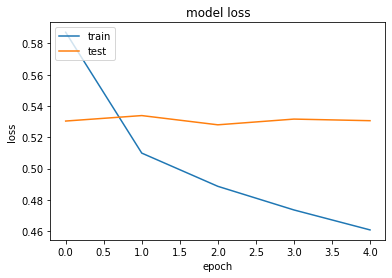

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


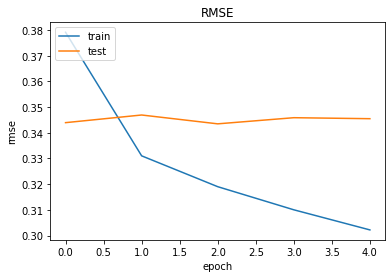

In [ ]:
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("RMSE")
plt.ylabel("rmse")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-09-17 08:25:43--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  18.8MB/s    in 0.5s    

2021-09-17 08:25:43 (18.8 MB/s) - ‘meta_All_Beauty.json.gz’ saved [10329961/10329961]



In [ ]:

data = []
with gzip.open('meta_All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    


In [ ]:
df3 = pd.DataFrame.from_dict(data)

Recommendations for users who has given atleast one review

In [ ]:
product_df = df.asin

user_id = df.reviewerID.sample(1).iloc[0]
products_reviwed = df[df.reviewerID == user_id]
products_not_reviewed = product_df[~product_df.isin(products_reviwed.asin.values)]
products_not_reviewed = list(set(products_not_reviewed).intersection(set(product2product_encoded.keys())))
products_not_reviewed = [[product2product_encoded.get(x)] for x in products_not_reviewed]
user_encoder = user2user_encoded.get(user_id)
user_product_array = np.hstack(([[user_encoder]] * len(products_not_reviewed), products_not_reviewed))
ratings = model.predict(user_product_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_product_ids = [product_encoded2product.get(products_not_reviewed[x][0]) for x in top_ratings_indices]
user_id, recommended_product_ids

('AAR759IGHB7LE',
 ['B0010DMNFQ',
  'B00020UR4C',
  'B004LUQRJI',
  'B000KNELAW',
  'B0009RF9DW',
  'B000FI4S1E',
  'B000WZHGVY',
  'B01EGH00J8',
  'B000UYCKRC',
  'B0012Y0ZG2'])

In [ ]:
ar = []
for i in recommended_product_ids:
  print(str(df3.loc[df3['asin']==i,'title'].unique))

<bound method Series.unique of 2367    BriteSmile Mouth Rinse 14 oz
Name: title, dtype: object>
<bound method Series.unique of 282    Truefitt &amp; Hill Trafalgar After Shave Spla...
686    Truefitt &amp; Hill Trafalgar After Shave Spla...
Name: title, dtype: object>
<bound method Series.unique of 5206    Paul Brown Hawaii Hapuna Hair Styling Paste, 8...
Name: title, dtype: object>
<bound method Series.unique of 1561    Death and Dentistry
Name: title, dtype: object>
<bound method Series.unique of 993    Yardley By Yardley Of London Unisexs Lay It On...
Name: title, dtype: object>
<bound method Series.unique of 1236    Fruits &amp; Passion Blue Refreshing Shower Ge...
Name: title, dtype: object>
<bound method Series.unique of 2255    Bare Escentuals Trudy Face Color 2.8 g NEW - S...
Name: title, dtype: object>
<bound method Series.unique of 30622    How To Train Your Dragon - Record Store Day 20...
Name: title, dtype: object>
<bound method Series.unique of 2096    Commonwealth Lavare 

In [ ]:
df.iloc[0]

asin              B00V6F0CJM
reviewerID    A35U9OU28XKQMU
overall                    3
time              1453334400
time1             2016/21/01
Year                    2016
user                  254843
product                19425
Name: 324452, dtype: object

In [ ]:
df = df.sort_values(by='overall', ascending = False)
df = df[(df['overall'] >= 4) & (df['Year']>=2017)]
df.head

<bound method NDFrame.head of               asin      reviewerID  overall  ...  Year    user  product
344942  B0182BVL4M  A28H72UFHPN9QN      5.0  ...  2018  272981    24386
341565  B016X29TXW  A2VGJTJ3BQMAG5      5.0  ...  2018  266640     3163
320141  B00SABWUL8  A388IB702CP8VZ      5.0  ...  2018  251049    18250
6116    B000050FDY   ASZT9X2MF25BJ      5.0  ...  2017    5820       11
353320  B01BH8FGA2  A31DY8NZLQ0CE1      5.0  ...  2017  280429     3596
...            ...             ...      ...  ...   ...     ...      ...
352726  B01B6SLUYE  A3C9N8IS4RYEZQ      4.0  ...  2017  279897     3576
217614  B017M402PO  A2F74OURQCIY3Q      4.0  ...  2018  164022     3250
160882  B00JIESMR2  A36175NJEOHHG7      4.0  ...  2018  111778     1682
232330  B01BZV6VVY  A2L02OQFDR721M      4.0  ...  2018   72591     3659
54185   B000YB70PS   ABIOVHOL63D4H      4.0  ...  2017   37019      290

[73888 rows x 8 columns]>

General recommendations for new user:

In [ ]:
recommended_product_ids = df.asin.sample(n = 10)

In [ ]:
ar = []
for i in recommended_product_ids:
  print(str(df3.loc[df3['asin']==i,'title']))

23810    NION Opus - #1 International Facial Cleansing ...
Name: title, dtype: object
7901    AVS Kottamchukkadi Tailam 200ml
Name: title, dtype: object
3606    Astra Platinum Double Edge Safety Razor Blades...
Name: title, dtype: object
18435    Recover Gold Core Timeless Face Serum
Name: title, dtype: object
35     Braun Clean &amp; Renew Refill Cartridges CCR ...
439    Braun Clean &amp; Renew Refill Cartridges CCR ...
Name: title, dtype: object
23962    Greenwich Bay Trading Company Fall &amp; Winte...
Name: title, dtype: object
11396    Fabulous Frannie Blend Sampler Gift Set Pure E...
Name: title, dtype: object
32798    Barnhouse - Lavender - Premium Grade Fragrance...
Name: title, dtype: object
5220    Axe Detailer 2-Sided Shower Tool, Colors May V...
Name: title, dtype: object
1935    Soap Bark &amp; Chamomile Deep Cleansing Cream...
Name: title, dtype: object
